In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [30]:
# The single-node SIS epidemic model is goverend by two parameters.
# beta: infection rate, gamma: recovery rate

beta=0.3
gamma=0.2
h=0.5             # discretization time-step
x_0=0.05          # infected fraction at the start
num_iter=200      # number of iterations
Actual_R0 = beta/gamma

In [9]:
#Data Generation
x=[]
x.append(x_0)
for i in range (1,num_iter):
  x.append(x[i-1]+x[i-1]*(beta*(1-x[i-1])-gamma)*h+1e-6*np.random.rand())     # the last term is a noise added to the dynamics

In [10]:
x=np.array(x)
x=x.reshape(num_iter,1)
x_transpose= x.reshape(1,num_iter)
x_transpose.shape


(1, 200)

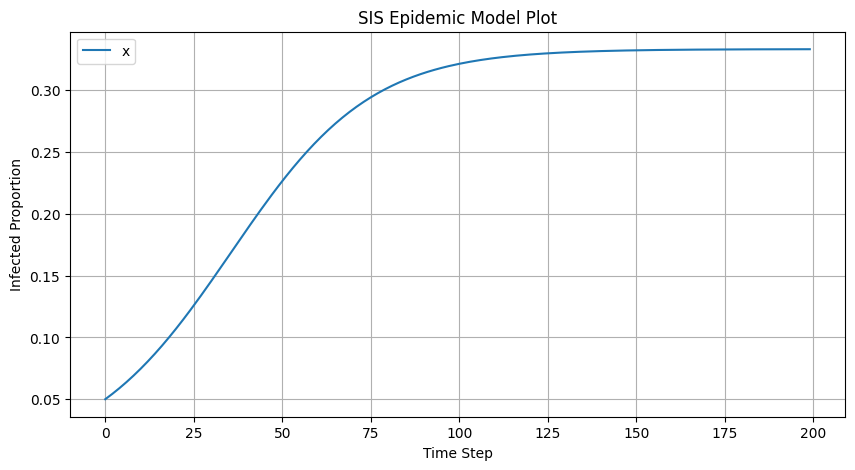

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, num_iter), x, label='x')
plt.xlabel('Time Step')
plt.ylabel('Infected Proportion')
plt.legend()
plt.title('SIS Epidemic Model Plot')
plt.grid(True)
plt.show()

In [12]:
A=np.dot(x,x_transpose)
A.shape

(200, 200)

In [ ]:
#kappa=np.linalg.cond(A)
#kappa
# Very High Condition no., almost tending towards infinity. Hence Ill-Conditioned Matrix

In [13]:
# The regressor matrix is being set up here: y = \phi*theta where theta = [beta,gamma] is the vector of unknown parameters.

cols=2
rows=num_iter
size = rows*cols
phi = np.array([0.00]*size).reshape(rows,cols)
y=np.array([0.00]*num_iter)
for i in range(num_iter-1):
  phi[i][0] = (1-x[i])*x[i]
  phi[i][1] = -x[i]
  y[i]= (x[i+1]-x[i])/h

print(y.shape)

(200,)


# **Gradient Descent Estimate**

In [14]:
#Initialize GD Parameters
theta_GD = np.full((2, 1), 0.6)
estimated_GD_beta_values = []
estimated_GD_gamma_values = []

In [15]:
for i in range(num_iter-1):
  phi_i = phi[i].reshape(1,2)
  y_i = y[i]
  theta_GD=theta_GD+phi_i.T.dot(y_i-phi_i.dot(theta_GD))
  estimated_GD_beta_values.append(theta_GD[0])
  estimated_GD_gamma_values.append(theta_GD[1])

## **RLS Estimation**

In [16]:
# Initialize RLS parameters
P = 1e3*np.identity(2)
theta = np.full((2, 1), 0.6)
lambda_ = 0.94

estimated_beta_values = []
estimated_gamma_values = []

In [17]:
for i in range(num_iter-1):
    phi_i = phi[i].reshape(1,2)
    y_i = y[i]

    # RLS update
    K = P.dot(phi_i.T) / (lambda_ + phi_i.dot(P).dot(phi_i.T))
    P = (P - K.dot(phi_i).dot(P))*(1 / lambda_)
    theta = theta + P.dot((phi_i.T*y_i - phi_i.T @ phi_i.dot(theta)))


    estimated_beta_values.append(theta[0])
    estimated_gamma_values.append(theta[1])

# **R0 Visualization**

In [28]:
#RLS
estimated_beta_values_array=np.array(estimated_beta_values)
estimated_gamma_values_array=np.array(estimated_gamma_values)
estimated_R0_RLS=estimated_beta_values_array/estimated_gamma_values_array
#GD
estimated_GD_beta_values_array=np.array(estimated_GD_beta_values)
estimated_GD_gamma_values_array=np.array(estimated_GD_gamma_values)
estimated_R0_GD=estimated_GD_beta_values_array/estimated_GD_gamma_values_array

## **GRLS Estimation**

In [18]:
from scipy.linalg import eigvals

In [19]:
#Function Definitions

def phi_tr_phi(x):
    phi_var=np.zeros((1,2))
    phi_var[0][0]= (1-x)*x
    phi_var[0][1]= -x
    phi_T_phi=(phi_var.T).dot(phi_var)
    #print(phi.T_phi.shape)
    return phi_T_phi

def phi_G(x):
    phi_var=np.zeros((1,2))
    phi_var[0][0]= (1-x)*x
    phi_var[0][1]= -x
    phi
    return phi_var

def condition_no (Z):
  Eigs = np.sort(np.linalg.eigvals(Z.T@Z))
  return np.infty if Eigs[0] == 0 else np.sqrt(Eigs[-1])/np.sqrt(Eigs[0])

In [20]:
alpha=0.94
mu=1e3
# Initialize GRLS parameters
H_curr=np.zeros((2,2))
Pk = np.eye(2)*mu
alt=math.sqrt(1-alpha)
#print(alt)
theta_2 = np.full((2, 1), 0.6)
#lambda_ = 0.9
#H_new= phi_tr_phi(x[0])

PH =phi[0].reshape(1,2)
ve=np.zeros((2,1))


theta_list=[]


In [21]:
#Temporary Space
#mu.shape
PH.shape

#print(alt)

(1, 2)

In [22]:
estimated_grls_beta_values = []
estimated_grls_gamma_values = []
for i in range(num_iter-1):
    #phi_T_phi_i=phi_tr_phi(x[i])
    phi_i=phi[i].reshape(1,2)
    H_new = H_curr + phi_i.T @ (phi_i)
    Kappa_new=condition_no(H_new)
    Kappa=condition_no(H_curr)
    if (Kappa_new < Kappa):
      H_curr=H_new
      #print("1")
      PH=np.vstack([PH,phi_i])
      ve=ve+phi_i.T*((x[i+1]-x[i])/h)
      Phi=alt*PH
      H=(1-alpha)*H_curr
      v=(1-alpha)*ve
    else:
      #print("2")
      #H_new=H_curr
      Phi=np.vstack([alt*PH,phi_i])
      H=(1-alpha)*H_curr+phi_i.T.dot(phi_i)
      v=(1-alpha)*ve+phi_i.T*((x[i+1]-x[i])/h)
    # Update
    inner=Phi.dot(Pk).dot(Phi.T)
    N=np.linalg.inv(alpha*(np.eye(inner.shape[0]))+inner)
    #print(N)
    Pk = (Pk - Pk @ (Phi.T) @ (N) @ (Phi) @ (Pk))*(1/alpha)
    #print(Pk)
    theta_2 = theta_2 + Pk@(v - H.dot(theta_2))
    #print(theta_2)


    estimated_grls_beta_values.append(theta_2[0])
    estimated_grls_gamma_values.append(theta_2[1])

<ipython-input-19-1a40d46dae21>:20: RuntimeWarning: invalid value encountered in sqrt
  return np.infty if Eigs[0] == 0 else np.sqrt(Eigs[-1])/np.sqrt(Eigs[0])


In [23]:
print(v.shape)
print(estimated_grls_gamma_values)

(2, 1)
[array([0.55193013]), array([0.54592959]), array([0.54338975]), array([0.54187475]), array([0.54078703]), array([0.53990789]), array([0.53985056]), array([0.53971689]), array([0.53949048]), array([0.53916026]), array([0.53872103]), array([0.53817391]), array([0.53752283]), array([0.53677113]), array([0.53591802]), array([0.53495589]), array([0.5338684]), array([0.53262843]), array([0.5311971]), array([0.5295222]), array([0.52753623]), array([0.52515666]), array([0.52228472]), array([0.51880314]), array([0.51457933]), array([0.50946788]), array([0.50331422]), array([0.49596494]), array([0.48728312]), array([0.47716029]), array([0.46554109]), array([0.45243728]), array([0.43794566]), array([0.42225358]), array([0.40563451]), array([0.38843341]), array([0.37103074]), array([0.35381774]), array([0.3371538]), array([0.32134069]), array([0.30660841]), array([0.29310717]), array([0.28091136]), array([0.27003119]), array([0.26042532]), array([0.2520182]), array([0.24471113]), array([0.2

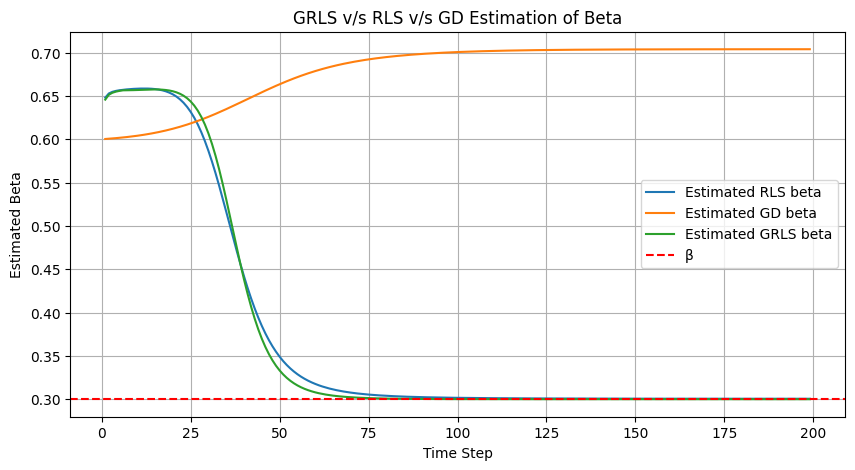

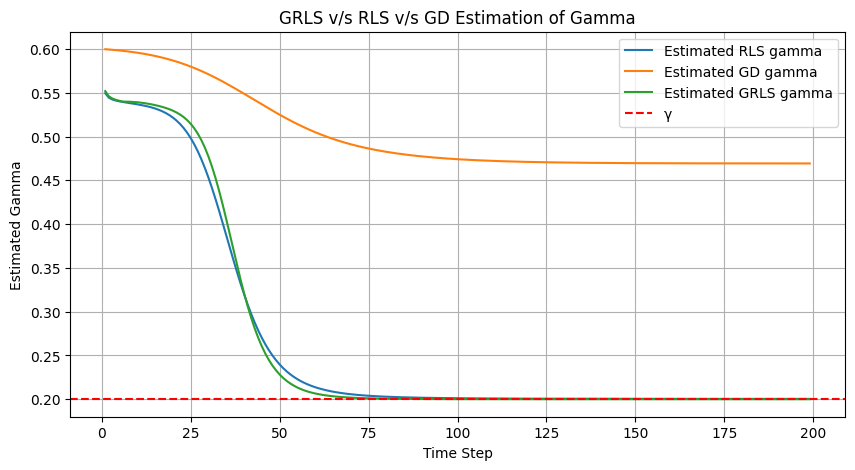

In [24]:
# Plotting the estimated values using RLS Estimation
plt.figure(figsize=(10, 5))
#plt.ylim(0,0.3)
plt.plot(range(1, num_iter), estimated_beta_values, label='Estimated RLS beta')
plt.plot(range(1, num_iter), estimated_GD_beta_values, label='Estimated GD beta')
plt.plot(range(1,num_iter), estimated_grls_beta_values, label='Estimated GRLS beta')
plt.axhline(y=beta, color='red', linestyle='--', label='β')
plt.xlabel('Time Step')
plt.ylabel('Estimated Beta')
plt.legend()
plt.title('GRLS v/s RLS v/s GD Estimation of Beta')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))
#plt.ylim(0.1,0.2)
plt.plot(range(1, num_iter), estimated_gamma_values, label='Estimated RLS gamma')
plt.plot(range(1, num_iter), estimated_GD_gamma_values, label='Estimated GD gamma')
plt.plot(range(1, num_iter), estimated_grls_gamma_values, label='Estimated GRLS gamma')
plt.axhline(gamma, color='red', linestyle='--', label='γ')
plt.xlabel('Time Step')
plt.ylabel('Estimated Gamma')
plt.legend()
plt.title('GRLS v/s RLS v/s GD Estimation of Gamma')
plt.grid(True)
plt.show()


In [26]:
final_grls_estimated_beta = estimated_grls_beta_values[-1]
final_grls_estimated_gamma = estimated_grls_gamma_values[-1]

print(f"Final Estimated beta: {final_grls_estimated_beta}")
print(f"Final Estimated gamma: {final_grls_estimated_gamma}")

Final Estimated beta: [0.30002112]
Final Estimated gamma: [0.2000114]


In [25]:
#GRLS
estimated_grls_beta_values_array=np.array(estimated_grls_beta_values)
estimated_grls_gamma_values_array=np.array(estimated_grls_gamma_values)
estimated_R0_grls=estimated_grls_beta_values_array/estimated_grls_gamma_values_array

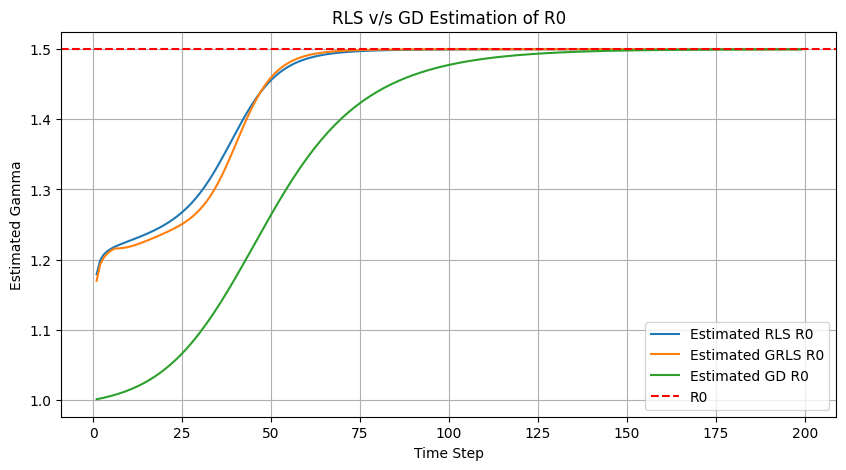

In [31]:
plt.figure(figsize=(10, 5))
#plt.ylim(-2,3)
plt.plot(range(1, num_iter), estimated_R0_RLS, label='Estimated RLS R0')
plt.plot(range(1, num_iter), estimated_R0_grls, label='Estimated GRLS R0')
plt.plot(range(1, num_iter), estimated_R0_GD, label='Estimated GD R0')

plt.axhline(Actual_R0, color='red', linestyle='--', label='R0')
plt.xlabel('Time Step')
plt.ylabel('Estimated Gamma')
plt.legend()
plt.title('RLS v/s GD Estimation of R0')
plt.grid(True)
plt.show()